In [ ]:
# 08 Analyzing Subject Alternative Names in Server Certificates


website_dataの分析を開始...
取得したレコード数: 11096

normal_sitesの分析を開始...
取得したレコード数: 9591

=== 証明書分析サマリー ===

website_data:
総証明書数: 11,096
有効な証明書: 6,986 (63.0%)
無効な証明書: 4,110 (37.0%)

マルチドメイン証明書数: 5,751
マルチドメイン証明書の割合: 82.3%
証明書あたりの平均ドメイン数: 47.10
証明書あたりの最大ドメイン数: 139

ドメイン数の分布:
1ドメイン: 1,235 件 (17.7%)
2ドメイン: 1,168 件 (16.7%)
3ドメイン: 50 件 (0.7%)
4ドメイン: 81 件 (1.2%)
5ドメイン: 269 件 (3.9%)
6ドメイン: 50 件 (0.7%)
7ドメイン: 74 件 (1.1%)
8ドメイン: 73 件 (1.0%)
9ドメイン: 75 件 (1.1%)
10ドメイン: 69 件 (1.0%)
11ドメイン: 21 件 (0.3%)
12ドメイン: 22 件 (0.3%)
13ドメイン: 13 件 (0.2%)
14ドメイン: 3 件 (0.0%)
15ドメイン: 7 件 (0.1%)
16ドメイン: 16 件 (0.2%)
17ドメイン: 22 件 (0.3%)
18ドメイン: 3 件 (0.0%)
19ドメイン: 4 件 (0.1%)
20ドメイン: 52 件 (0.7%)
22ドメイン: 4 件 (0.1%)
24ドメイン: 35 件 (0.5%)
25ドメイン: 2 件 (0.0%)
26ドメイン: 2 件 (0.0%)
28ドメイン: 1 件 (0.0%)
30ドメイン: 35 件 (0.5%)
31ドメイン: 1 件 (0.0%)
32ドメイン: 8 件 (0.1%)
34ドメイン: 2 件 (0.0%)
35ドメイン: 5 件 (0.1%)
36ドメイン: 2 件 (0.0%)
38ドメイン: 1 件 (0.0%)
40ドメイン: 270 件 (3.9%)
41ドメイン: 24 件 (0.3%)
48ドメイン: 1 件 (0.0%)
50ドメイン: 397 件 (5.7%)
52ドメイン: 53 件 (0.8%)
53ドメイン: 

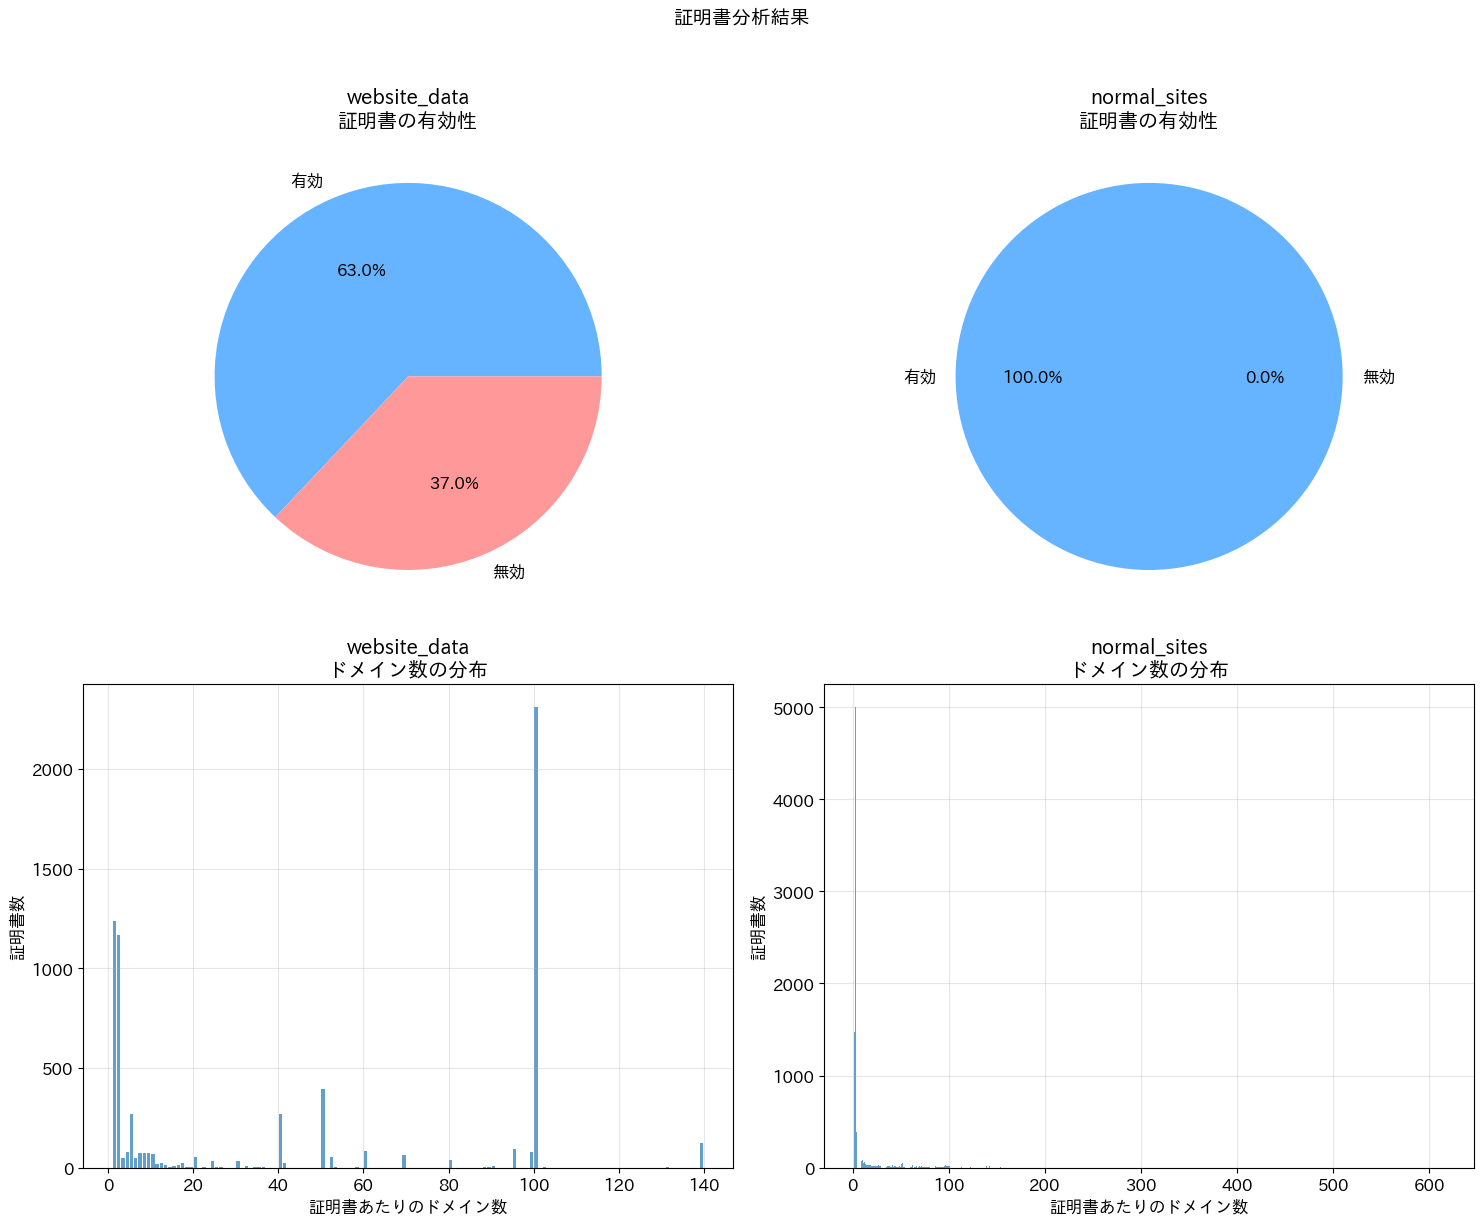

In [3]:
# 04_improved_certificate_analysis.ipynb
# Location: RAPIDS/notebooks/certificate_analysis/04_improved_certificate_analysis.ipynb

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import json
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import binascii
import matplotlib.pyplot as plt
import japanize_matplotlib
from typing import Dict, List, Tuple, Optional
import re
from datetime import datetime
from pathlib import Path

class CertificateAnalyzer:
    """証明書の分析を行うクラス（改善版）"""
    
    def __init__(self, config_path: str):
        """初期化"""
        # 設定の読み込み
        with open(config_path) as f:
            self.config = json.load(f)['database']
        
        # 出力ディレクトリの設定
        self.output_dir = Path('/home/asomura/waseda/nextstep/RAPIDS/reports/certificate_analysis')
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # フォント設定
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['IPAexGothic', 'IPAPGothic', 'Yu Gothic']
        
        # エラー統計の初期化
        self.error_stats = {
            'total_processed': 0,
            'success': 0,
            'failures': {
                'asn1_error': 0,
                'hex_error': 0,
                'parse_error': 0,
                'no_domain_error': 0,
                'other_error': 0
            }
        }
        
        # 詳細な結果格納用
        self.detailed_results = []

    def get_engine(self, db_name: str) -> create_engine:
        """データベース接続エンジンを取得"""
        host = 'localhost' if db_name == 'website_data' else '192.168.1.92'
        return create_engine(
            f'postgresql://{self.config["user"]}:{self.config["password"]}@{host}/{db_name}'
        )

    def clean_cert_data(self, cert_data: str) -> Optional[bytes]:
        """証明書データのクリーニングと変換"""
        try:
            if not cert_data:
                return None
            
            # \xプレフィックスとスペースの除去
            hex_str = cert_data.replace('\\x', '').replace(' ', '')
            
            # 16進数以外の文字を除去
            hex_str = re.sub(r'[^0-9a-fA-F]', '', hex_str)
            
            # 奇数長の場合、0を追加
            if len(hex_str) % 2 != 0:
                hex_str += '0'
            
            return binascii.unhexlify(hex_str)
            
        except (binascii.Error, ValueError) as e:
            self.error_stats['failures']['hex_error'] += 1
            return None

    def extract_domains(self, cert_data: str, original_domain: str) -> Dict:
        """証明書からドメイン情報を抽出（改善版）"""
        self.error_stats['total_processed'] += 1
        
        try:
            # データのクリーニングと変換
            binary_data = self.clean_cert_data(cert_data)
            if not binary_data:
                raise ValueError("Invalid certificate data")
            
            # 証明書の解析
            cert = x509.load_der_x509_certificate(binary_data, default_backend())
            domains = set()  # 重複を避けるためにsetを使用
            
            # SANから取得を試みる
            for extension in cert.extensions:
                if isinstance(extension.value, x509.SubjectAlternativeName):
                    san_domains = [name.value for name in extension.value 
                                 if isinstance(name, x509.DNSName)]
                    domains.update(san_domains)
            
            # Common Nameからも取得
            try:
                cn = cert.subject.get_attributes_for_oid(x509.NameOID.COMMON_NAME)
                if cn:
                    domains.add(cn[0].value)
            except Exception:
                pass  # CNの取得に失敗しても続行
            
            # ドメインのリストに変換
            domain_list = sorted(list(domains))
            
            # 最低1つのドメインがない場合はエラー
            if not domain_list:
                self.error_stats['failures']['no_domain_error'] += 1
                return self._create_error_result(original_domain, "No valid domains found")
            
            self.error_stats['success'] += 1
            
            return {
                'original_domain': original_domain,
                'domain_count': len(domain_list),
                'domains': domain_list,
                'is_multi_domain': len(domain_list) > 1,
                'error': None
            }
            
        except ValueError as e:
            self.error_stats['failures']['parse_error'] += 1
            return self._create_error_result(original_domain, f"Parse error: {str(e)}")
            
        except Exception as e:
            if "error parsing asn1 value" in str(e).lower():
                self.error_stats['failures']['asn1_error'] += 1
                return self._create_error_result(original_domain, "ASN.1 parse error")
            else:
                self.error_stats['failures']['other_error'] += 1
                return self._create_error_result(original_domain, f"Error: {str(e)}")

    def _create_error_result(self, domain: str, error_msg: str) -> Dict:
        """エラー結果の生成"""
        return {
            'original_domain': domain,
            'domain_count': 0,
            'domains': [],
            'is_multi_domain': False,
            'error': error_msg
        }

    def analyze_certificates(self, db_name: str) -> Dict:
        """証明書の分析を実行"""
        print(f"\n{db_name}の分析を開始...")
        
        # データの取得
        engine = self.get_engine(db_name)
        query = """
            SELECT domain, https_certificate_body 
            FROM website_data 
            WHERE status = 7 
              AND https_certificate_body IS NOT NULL;
        """
        df = pd.read_sql_query(query, engine)
        print(f"取得したレコード数: {len(df)}")
        
        # 各証明書の分析
        results = []
        for _, row in df.iterrows():
            result = self.extract_domains(row['https_certificate_body'], row['domain'])
            results.append(result)
            self.detailed_results.append({
                **result, 
                'database': db_name,
                'timestamp': datetime.now()
            })
        
        # 有効な結果のみを使用して統計を計算
        valid_results = [r for r in results if r['domain_count'] > 0]
        
        # 統計の計算
        total_certs = len(results)
        total_valid = len(valid_results)
        multi_domain_certs = sum(1 for r in valid_results if r['is_multi_domain'])
        domain_counts = [r['domain_count'] for r in valid_results]
        
        return {
            'total_certificates': total_certs,
            'valid_certificates': total_valid,
            'invalid_certificates': total_certs - total_valid,
            'multi_domain_certificates': multi_domain_certs,
            'multi_domain_ratio': multi_domain_certs / total_valid if total_valid > 0 else 0,
            'domain_counts': domain_counts,
            'avg_domains_per_cert': np.mean(domain_counts) if domain_counts else 0,
            'max_domains_per_cert': max(domain_counts) if domain_counts else 0,
            'results': results
        }

    def save_detailed_results(self, output_path: Optional[str] = None):
        """詳細な分析結果をCSVファイルとして保存"""
        if not output_path:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            output_path = self.output_dir / f'cert_analysis_{timestamp}.csv'
        
        df = pd.DataFrame(self.detailed_results)
        # domainsリストをカンマ区切りの文字列に変換
        df['domains'] = df['domains'].apply(lambda x: ','.join(x) if isinstance(x, list) else '')
        df.to_csv(output_path, index=False)
        print(f"\n詳細な分析結果を保存: {output_path}")

    def print_summary(self, results: Dict[str, Dict]):
        """分析結果のサマリーを表示"""
        print("\n=== 証明書分析サマリー ===")
        
        for db_name, data in results.items():
            print(f"\n{db_name}:")
            print(f"総証明書数: {data['total_certificates']:,}")
            print(f"有効な証明書: {data['valid_certificates']:,} ({data['valid_certificates']/data['total_certificates']*100:.1f}%)")
            print(f"無効な証明書: {data['invalid_certificates']:,} ({data['invalid_certificates']/data['total_certificates']*100:.1f}%)")
            
            if data['valid_certificates'] > 0:
                print(f"\nマルチドメイン証明書数: {data['multi_domain_certificates']:,}")
                print(f"マルチドメイン証明書の割合: {data['multi_domain_ratio']:.1%}")
                print(f"証明書あたりの平均ドメイン数: {data['avg_domains_per_cert']:.2f}")
                print(f"証明書あたりの最大ドメイン数: {data['max_domains_per_cert']}")
                
                # ドメイン数の分布
                domain_counts = pd.Series(data['domain_counts'])
                print("\nドメイン数の分布:")
                for count, freq in domain_counts.value_counts().sort_index().items():
                    print(f"{count}ドメイン: {freq:,} 件 ({freq/len(domain_counts):.1%})")

    def print_error_stats(self):
        """エラー統計の表示"""
        print("\n=== エラー統計 ===")
        total = self.error_stats['total_processed']
        print(f"処理した証明書の総数: {total:,}")
        print(f"成功: {self.error_stats['success']:,} ({self.error_stats['success']/total*100:.1f}%)")
        
        print("\nエラーの内訳:")
        for error_type, count in self.error_stats['failures'].items():
            if count > 0:
                print(f"- {error_type}: {count:,} ({count/total*100:.1f}%)")

    def plot_results(self, results: Dict[str, Dict]):
        """分析結果の可視化"""
        # フォントサイズの設定
        plt.rcParams['font.size'] = 12
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('証明書分析結果', y=1.02, fontsize=14)
        
        for db_name, data in results.items():
            if data['valid_certificates'] == 0:
                continue
            
            # 1. 証明書の有効性の円グラフ
            ax = ax1 if db_name == 'website_data' else ax2
            valid_ratio = data['valid_certificates'] / data['total_certificates']
            ax.pie([valid_ratio, 1-valid_ratio],
                  labels=['有効', '無効'],
                  autopct='%1.1f%%',
                  colors=['#66b3ff', '#ff9999'])
            ax.set_title(f'{db_name}\n証明書の有効性')
            
            # 2. ドメイン数の分布
            ax = ax3 if db_name == 'website_data' else ax4
            domain_counts = pd.Series(data['domain_counts'])
            ax.hist(domain_counts, 
                   bins=range(1, int(max(domain_counts)) + 2),
                   alpha=0.7,
                   rwidth=0.8)
            ax.set_title(f'{db_name}\nドメイン数の分布')
            ax.set_xlabel('証明書あたりのドメイン数')
            ax.set_ylabel('証明書数')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()

def main():
    # 設定
    config_path = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'
    
    # 分析の実行
    analyzer = CertificateAnalyzer(config_path)
    
    results = {
        'website_data': analyzer.analyze_certificates('website_data'),
        'normal_sites': analyzer.analyze_certificates('normal_sites')
    }
    
    # 結果の表示
    analyzer.print_summary(results)
    analyzer.print_error_stats()
    analyzer.plot_results(results)
    
    # 詳細結果の保存
    analyzer.save_detailed_results()

if __name__ == "__main__":
    main()

In [2]:
# 05_certificate_error_analysis.ipynb
# Location: RAPIDS/notebooks/certificate_analysis/05_certificate_error_analysis.ipynb

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import json
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import binascii
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re
from datetime import datetime

class CertificateErrorAnalyzer:
    """証明書の解析エラーを詳細に分析するクラス"""
    
    def __init__(self, config_path: str):
        """初期化"""
        with open(config_path) as f:
            self.config = json.load(f)['database']
            
        self.error_details = []
        
    def get_engine(self, db_name: str) -> create_engine:
        """データベース接続エンジンを取得"""
        host = 'localhost' if db_name == 'website_data' else '192.168.1.92'
        return create_engine(
            f'postgresql://{self.config["user"]}:{self.config["password"]}@{host}/{db_name}'
        )

    def examine_hex_data(self, cert_data: str) -> Dict:
        """16進数データの問題を詳細に分析"""
        if not cert_data:
            return {'error': 'Empty certificate data'}
            
        analysis = {
            'length': len(cert_data),
            'starts_with_x': cert_data.startswith('\\x'),
            'contains_non_hex': bool(re.search(r'[^0-9a-fA-F\\x\s]', cert_data)),
            'has_odd_length': len(re.sub(r'[^0-9a-fA-F]', '', cert_data)) % 2 != 0
        }
        
        # 最初の数バイトを表示（デバッグ用）
        clean_hex = re.sub(r'[^0-9a-fA-F]', '', cert_data)
        analysis['hex_preview'] = clean_hex[:20] if clean_hex else 'No hex data'
        
        return analysis

    def analyze_certificate_errors(self, db_name: str) -> pd.DataFrame:
        """証明書の解析エラーを分析"""
        engine = self.get_engine(db_name)
        query = """
            SELECT domain, https_certificate_body 
            FROM website_data 
            WHERE status = 7 
              AND https_certificate_body IS NOT NULL
            LIMIT 100;  -- 最初の100件で試験
        """
        
        df = pd.read_sql_query(query, engine)
        error_records = []
        
        for _, row in df.iterrows():
            domain = row['domain']
            cert_data = row['https_certificate_body']
            
            # 16進数データの分析
            hex_analysis = self.examine_hex_data(cert_data)
            
            try:
                # クリーニングを試行
                clean_hex = re.sub(r'[^0-9a-fA-F]', '', cert_data)
                if len(clean_hex) % 2 != 0:
                    clean_hex += '0'
                
                # バイナリデータへの変換を試行
                try:
                    binary_data = binascii.unhexlify(clean_hex)
                except binascii.Error as e:
                    error_records.append({
                        'domain': domain,
                        'error_type': 'hex_conversion_error',
                        'error_detail': str(e),
                        'data_analysis': hex_analysis
                    })
                    continue
                
                # 証明書としての解析を試行
                try:
                    cert = x509.load_der_x509_certificate(binary_data, default_backend())
                    
                    # SANの取得を試行
                    san_found = False
                    for extension in cert.extensions:
                        if isinstance(extension.value, x509.SubjectAlternativeName):
                            san_found = True
                            break
                            
                    if not san_found:
                        error_records.append({
                            'domain': domain,
                            'error_type': 'no_san_field',
                            'error_detail': 'SAN field not found in certificate',
                            'data_analysis': hex_analysis
                        })
                        
                except ValueError as e:
                    error_records.append({
                        'domain': domain,
                        'error_type': 'asn1_parse_error',
                        'error_detail': str(e),
                        'data_analysis': hex_analysis
                    })
                    
            except Exception as e:
                error_records.append({
                    'domain': domain,
                    'error_type': 'unexpected_error',
                    'error_detail': str(e),
                    'data_analysis': hex_analysis
                })
        
        return pd.DataFrame(error_records)

    def analyze_and_print_results(self, db_name: str):
        """エラー分析の実行と結果の表示"""
        print(f"\n{db_name}の証明書解析エラーの分析:")
        print("=" * 50)
        
        error_df = self.analyze_certificate_errors(db_name)
        
        if len(error_df) == 0:
            print("解析エラーは見つかりませんでした。")
            return
        
        # エラータイプごとの集計
        print("\nエラータイプの分布:")
        error_counts = error_df['error_type'].value_counts()
        for error_type, count in error_counts.items():
            print(f"{error_type}: {count}件")
        
        # 詳細なエラー分析
        print("\n代表的なエラーの詳細:")
        for error_type in error_df['error_type'].unique():
            print(f"\n{error_type}の例:")
            example = error_df[error_df['error_type'] == error_type].iloc[0]
            print(f"ドメイン: {example['domain']}")
            print(f"エラー詳細: {example['error_detail']}")
            print("データ分析:")
            for key, value in example['data_analysis'].items():
                print(f"- {key}: {value}")

def main():
    # 設定
    config_path = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'
    
    # 分析の実行
    analyzer = CertificateErrorAnalyzer(config_path)
    
    # 両データベースの分析
    databases = ['website_data', 'normal_sites']
    for db_name in databases:
        analyzer.analyze_and_print_results(db_name)

if __name__ == "__main__":
    main()


website_dataの証明書解析エラーの分析:

エラータイプの分布:
asn1_parse_error: 63件

代表的なエラーの詳細:

asn1_parse_errorの例:
ドメイン: 2ed7itr.duckdns.org
エラー詳細: error parsing asn1 value: ParseError { kind: InvalidLength }
データ分析:
- length: 4657
- starts_with_x: False
- contains_non_hex: True
- has_odd_length: False
- hex_preview: BECEFCAECCDCABAB415b

normal_sitesの証明書解析エラーの分析:
解析エラーは見つかりませんでした。
